/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1, Loss: 0.4026
Epoch 2, Loss: 0.2455
Epoch 3, Loss: 0.2098

Classification Report:
                 precision    recall  f1-score   support

Not LargeClass       0.89      0.99      0.94       160
    LargeClass       0.91      0.53      0.67        40

      accuracy                           0.90       200
     macro avg       0.90      0.76      0.80       200
  weighted avg       0.90      0.90      0.88       200



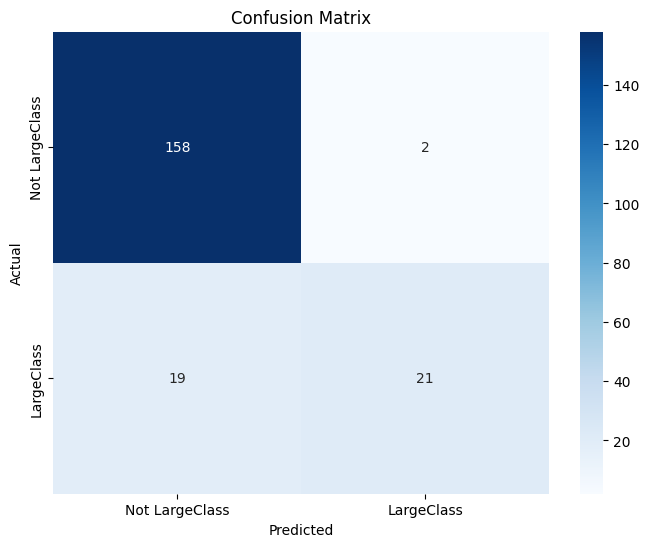

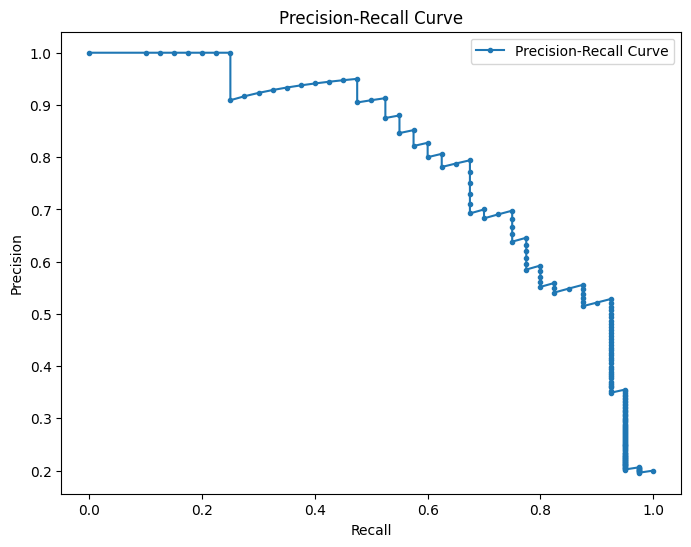

In [1]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define Hierarchical BERT Model
class HierarchicalBERT(nn.Module):
    def __init__(self, pretrained_model='bert-base-uncased', num_labels=2):
        super(HierarchicalBERT, self).__init__()

        # BERT models for feature groups
        self.code_metrics_bert = BertModel.from_pretrained(pretrained_model)
        self.halstead_metrics_bert = BertModel.from_pretrained(pretrained_model)

        # Aggregation and classification
        self.fc = nn.Linear(self.code_metrics_bert.config.hidden_size +
                            self.halstead_metrics_bert.config.hidden_size, num_labels)

    def forward(self, code_inputs, code_attention, halstead_inputs, halstead_attention):
        # Process Code Metrics group
        code_outputs = self.code_metrics_bert(input_ids=code_inputs, attention_mask=code_attention)
        code_cls_embedding = code_outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Process Halstead Metrics group
        halstead_outputs = self.halstead_metrics_bert(input_ids=halstead_inputs, attention_mask=halstead_attention)
        halstead_cls_embedding = halstead_outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Concatenate group embeddings
        combined_embedding = torch.cat([code_cls_embedding, halstead_cls_embedding], dim=1)

        # Classification
        logits = self.fc(combined_embedding)
        return logits

# Custom Dataset Class
class HierarchicalDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]

        # Prepare Code Metrics input
        code_metrics = f"LOC: {row['loc']}, Comments: {row['comments']}, Volume: {row['volume']}"
        code_encoding = self.tokenizer(
            code_metrics,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Prepare Halstead Metrics input
        halstead_metrics = f"Effort: {row['effort']}, Difficulty: {row['difficulty']}"
        halstead_encoding = self.tokenizer(
            halstead_metrics,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        label = row['LargeClass']

        return {
            'code_input_ids': code_encoding['input_ids'].squeeze(0),
            'code_attention_mask': code_encoding['attention_mask'].squeeze(0),
            'halstead_input_ids': halstead_encoding['input_ids'].squeeze(0),
            'halstead_attention_mask': halstead_encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load Dataset
data_path = 'lcd.csv'
data_df = pd.read_csv(data_path)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Train-Test Split
train_data, test_data = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['LargeClass'])
train_dataset = HierarchicalDataset(train_data, tokenizer, max_length=128)
test_dataset = HierarchicalDataset(test_data, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Initialize Model
model = HierarchicalBERT(pretrained_model='bert-base-uncased', num_labels=2)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Optimizer and Loss Function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_model():
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        # Move batch data to device
        code_input_ids = batch['code_input_ids'].to(device)
        code_attention_mask = batch['code_attention_mask'].to(device)
        halstead_input_ids = batch['halstead_input_ids'].to(device)
        halstead_attention_mask = batch['halstead_attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        logits = model(code_input_ids, code_attention_mask, halstead_input_ids, halstead_attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

# Evaluation Function
def evaluate_model():
    model.eval()
    preds, true_labels, probs = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            code_input_ids = batch['code_input_ids'].to(device)
            code_attention_mask = batch['code_attention_mask'].to(device)
            halstead_input_ids = batch['halstead_input_ids'].to(device)
            halstead_attention_mask = batch['halstead_attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(code_input_ids, code_attention_mask, halstead_input_ids, halstead_attention_mask)
            probabilities = torch.softmax(logits, dim=1)[:, 1]

            probs.extend(probabilities.cpu().numpy())
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Classification Report
    report = classification_report(true_labels, preds, target_names=['Not LargeClass', 'LargeClass'])
    print("\nClassification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not LargeClass', 'LargeClass'], yticklabels=['Not LargeClass', 'LargeClass'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(true_labels, probs)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

# Training Loop
for epoch in range(3):
    loss = train_model()
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

evaluate_model()
